# 1. Cargar las Librerías
En esta sección cargamos todas las librerías necesarias para el análisis y visualización de los vuelos y las rutas.

In [95]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import heapq
from collections import deque
from datetime import timedelta


# 2. Lectura del Archivo CSV
En esta parte, leemos el archivo CSV que contiene la información de los vuelos y mostramos un resumen de los datos cargados.

In [96]:
# Función para leer el archivo CSV y mostrar el DataFrame
def leer_archivo(archivo_csv):
    vuelos = pd.read_csv(archivo_csv)
    vuelos['Fecha_Salida'] = pd.to_datetime(vuelos['Fecha_Salida'] + ' ' + vuelos['Hora_Salida_Origen'])
    vuelos['Fecha_Llegada'] = pd.to_datetime(vuelos['Fecha_Llegada'] + ' ' + vuelos['Hora_Llegada_Destino'])
    vuelos['Duracion'] = vuelos['Fecha_Llegada'] - vuelos['Fecha_Salida']
    
    # Mostrar el DataFrame
    print("Datos de vuelos (DataFrame):")
    print(vuelos.head())  # Mostrar las primeras 5 filas del DataFrame
    
    return vuelos

# Cargar el archivo CSV
archivo_csv = 'ejemplosvuelos.csv'  # Cambia esto al nombre de tu archivo CSV
vuelos = leer_archivo(archivo_csv)


Datos de vuelos (DataFrame):
      ID   Origen Destino        Fecha_Salida Hora_Salida_Origen  \
0  VU001   Madrid    CDMX 2024-09-24 08:15:00              08:15   
1  VU002  Toronto  Madrid 2024-09-19 13:02:00              13:02   
2  VU003   Sídney    CDMX 2024-09-18 06:45:00              06:45   
3  VU004     Roma   Tokio 2024-09-26 00:48:00              00:48   
4  VU005    París   Tokio 2024-09-25 10:06:00              10:06   

        Fecha_Llegada Hora_Llegada_Destino  Precio_Vuelo          Duracion  
0 2024-09-25 04:47:00                04:47        243.49   0 days 20:32:00  
1 2024-09-19 02:13:00                02:13        425.73 -1 days +13:11:00  
2 2024-09-28 22:34:00                22:34        687.33  10 days 15:49:00  
3 2024-09-27 22:27:00                22:27        576.35   1 days 21:39:00  
4 2024-09-25 12:06:00                12:06        602.57   0 days 02:00:00  


# 3. Creación del Grafo de Vuelos
En esta sección, generamos el grafo dirigido que contiene las rutas de vuelos, y lo visualizamos con pesos en tiempo y costo.

In [97]:
# Función para crear un grafo dirigido a partir de los vuelos
def crear_grafo(vuelos):
    G = nx.DiGraph()  # Crear un grafo dirigido
    
    for idx, vuelo in vuelos.iterrows():
        origen = vuelo['Origen']
        destino = vuelo['Destino']
        tiempo = vuelo['Duracion'].total_seconds() / 3600  # Convertir duración a horas
        costo = vuelo['Precio_Vuelo']
        
        # Añadir arista con pesos de tiempo y costo
        G.add_edge(origen, destino, tiempo=tiempo, costo=costo)
    
    return G

# Crear el grafo de vuelos
G = crear_grafo(vuelos)


# 4. Visualización del Grafo de Vuelos
Aquí visualizamos el grafo de vuelos con pesos basados en el tiempo de vuelo y el costo del vuelo.

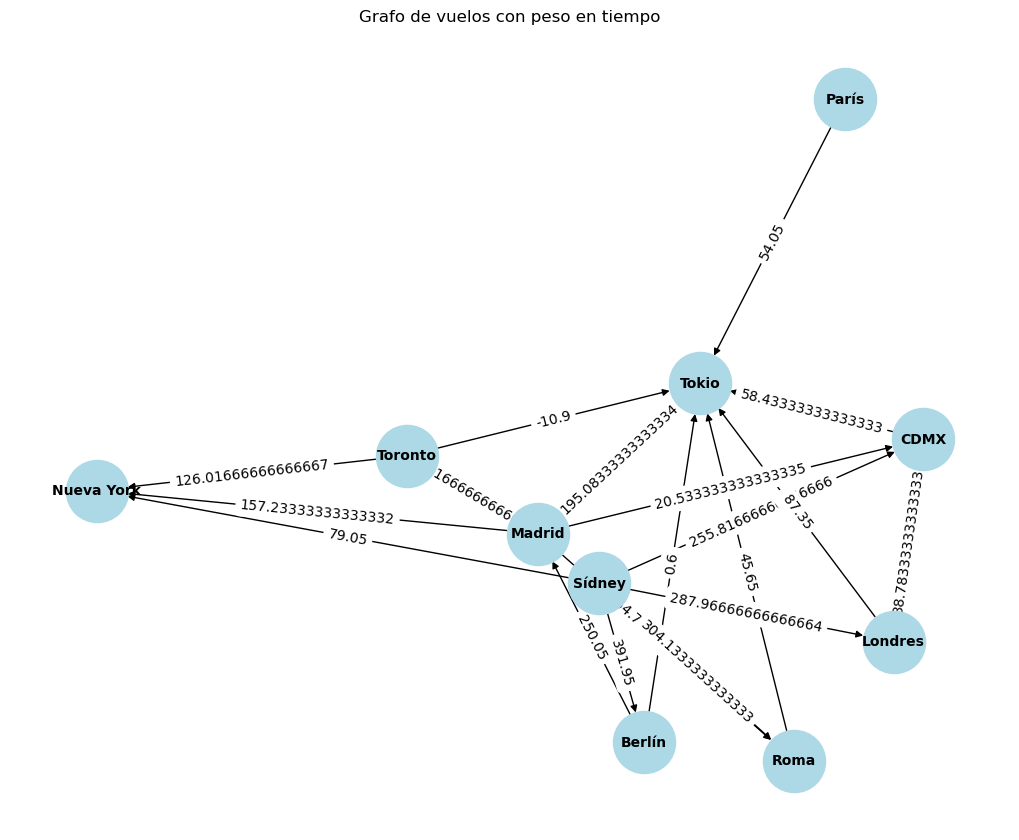

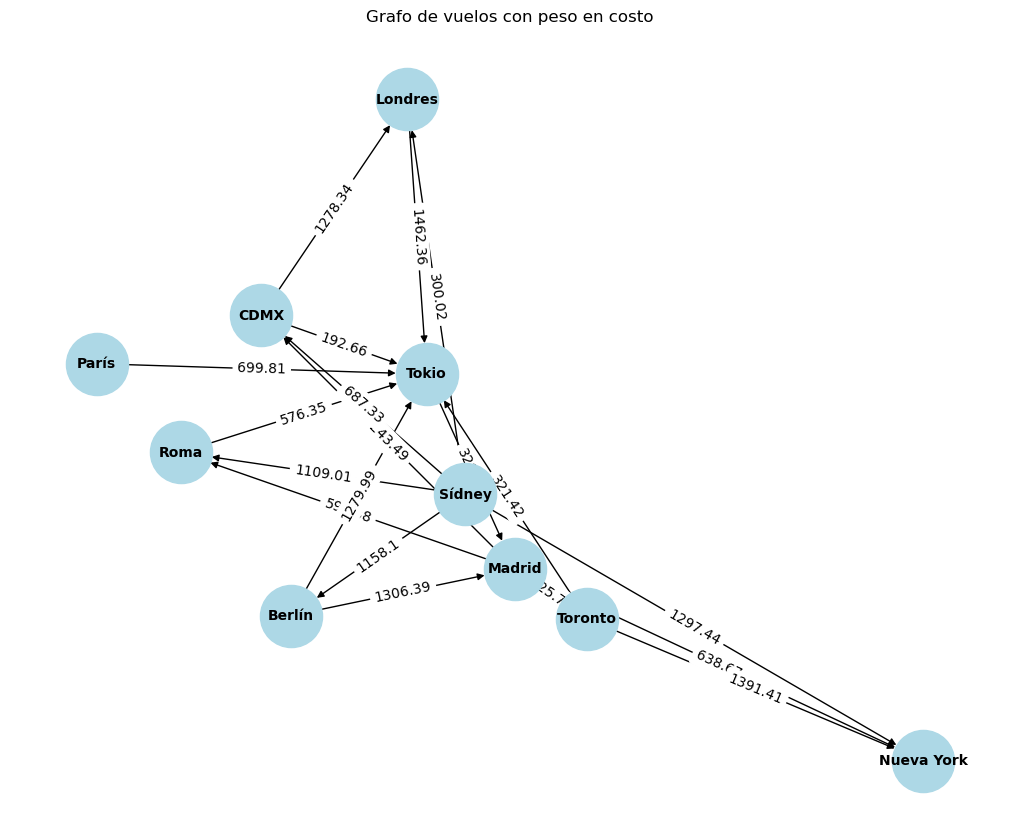

In [98]:
# Función para visualizar el grafo con pesos de tiempo o costo
def visualizar_grafo(G, peso='tiempo'):
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)  # Layout para la posición de los nodos
    
    labels = nx.get_edge_attributes(G, peso)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, font_weight='bold')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    
    plt.title(f"Grafo de vuelos con peso en {peso}")
    plt.show()

# Visualizar el grafo con peso en tiempo
visualizar_grafo(G, peso='tiempo')

# Visualizar el grafo con peso en costo
visualizar_grafo(G, peso='costo')


# 5. Algoritmo de Búsqueda por Costo Uniforme (en tiempo o dinero)
Aquí implementamos la búsqueda por costo uniforme para encontrar la ruta más rápida o económica entre dos ciudades.

In [99]:
def costo_uniforme(grafo, inicio, objetivo, tipo='tiempo'):
    """
    Algoritmo de búsqueda por costo uniforme.
    tipo: 'tiempo' o 'costo', determina qué peso usar para calcular la ruta más económica.
    """
    cola_prioridad = []
    heapq.heappush(cola_prioridad, (0, inicio, [inicio]))  # (costo, nodo actual, camino)
    visitados = set()
    while cola_prioridad:
        costo_actual, nodo_actual, camino = heapq.heappop(cola_prioridad)
        
        if nodo_actual == objetivo:
            return costo_actual, camino
        
        if nodo_actual not in visitados:
            visitados.add(nodo_actual)
            
            for vecino in grafo[nodo_actual]:
                nuevo_costo = costo_actual + grafo[nodo_actual][vecino][tipo]
                nuevo_camino = camino + [vecino]
                heapq.heappush(cola_prioridad, (nuevo_costo, vecino, nuevo_camino))
    return None, []  # Si no se encontró una ruta, devolvemos None en lugar de 'inf'

# Ejecutar el algoritmo de búsqueda por costo uniforme en tiempo
costo_tiempo, camino_tiempo = costo_uniforme(G, 'CDMX', 'Berlín', tipo='tiempo')
if camino_tiempo:
    print(f"Ruta más rápida en tiempo: {camino_tiempo} con un tiempo total de {costo_tiempo} horas")
else:
    print("No se encontró una ruta válida entre CDMX y Berlín en términos de tiempo.")


No se encontró una ruta válida entre CDMX y Berlín en términos de tiempo.


# 6. Algoritmos de Búsqueda en Amplitud (BFS) y Profundidad (DFS)
Se implementan los algoritmos BFS y DFS para encontrar todas las rutas posibles entre dos ciudades.

In [100]:
# Búsqueda en amplitud (BFS)
def busqueda_amplitud(grafo, inicio, objetivo):
    visitados = set()
    cola = deque([(inicio, [inicio])])
    caminos = []
    while cola:
        nodo_actual, camino = cola.popleft()
        if nodo_actual == objetivo:
            caminos.append(camino)
        if nodo_actual not in visitados:
            visitados.add(nodo_actual)
            for vecino in grafo[nodo_actual]:
                if vecino not in visitados:
                    nueva_ruta = camino + [vecino]
                    cola.append((vecino, nueva_ruta))
    return caminos if caminos else None

# Búsqueda en profundidad (DFS)
def dfs(grafo, inicio, objetivo, visitados=None, camino=None, caminos_encontrados=None):
    if visitados is None:
        visitados = set()
    if camino is None:
        camino = []
    if caminos_encontrados is None:
        caminos_encontrados = []
    camino.append(inicio)
    visitados.add(inicio)
    if inicio == objetivo:
        caminos_encontrados.append(camino.copy())
    else:
        for vecino in grafo[inicio]:
            if vecino not in visitados:
                dfs(grafo, vecino, objetivo, visitados, camino, caminos_encontrados)
    camino.pop()  
    visitados.remove(inicio)
    return caminos_encontrados if caminos_encontrados else None


Resultados de BFS


In [101]:
# Ejecutar búsqueda en amplitud y mostrar el resultado
rutas_bfs = busqueda_amplitud(G, 'CDMX', 'Berlín')
if rutas_bfs:
    print(f"Todas las rutas posibles (BFS) entre CDMX y Berlín:")
    for idx, ruta in enumerate(rutas_bfs, 1):
        print(f"Ruta {idx}: {' -> '.join(ruta)}")
else:
    print("No se encontró ninguna ruta válida entre CDMX y Berlín usando BFS.")


No se encontró ninguna ruta válida entre CDMX y Berlín usando BFS.


Resultados de DFS


In [102]:
# Ejecutar búsqueda en profundidad y mostrar el resultado
rutas_dfs = dfs(G, 'CDMX', 'Berlín')
if rutas_dfs:
    print(f"Todas las rutas posibles (DFS) entre CDMX y Berlín:")
    for idx, ruta in enumerate(rutas_dfs, 1):
        print(f"Ruta {idx}: {' -> '.join(ruta)}")
else:
    print("No se encontró ninguna ruta válida entre CDMX y Berlín usando DFS.")

No se encontró ninguna ruta válida entre CDMX y Berlín usando DFS.


# 7. Nodos y Rutas Accesibles desde una Ciudad
Aquí mostramos las rutas y nodos accesibles desde una ciudad usando BFS.

In [103]:
# Rutas accesibles directas o indirectas
def rutas_posibles(grafo, origen):
    """
    Función que devuelve todas las ciudades accesibles (directas o indirectas) desde 'origen' usando BFS.
    """
    visitados = set()
    cola = deque([origen])
    rutas = []
    while cola:
        nodo_actual = cola.popleft()
        if nodo_actual not in visitados:
            visitados.add(nodo_actual)
            rutas.append(nodo_actual)
            for vecino in grafo[nodo_actual]:
                if vecino not in visitados:
                    cola.append(vecino)
    return rutas if rutas else None

# Ciudad de origen: 'CDMX'
rutas_accesibles = rutas_posibles(G, 'CDMX')

if rutas_accesibles:
    print(f"Desde CDMX puedes volar directa o indirectamente a: {', '.join(rutas_accesibles)}")
else:
    print("No se encontraron rutas accesibles desde CDMX.")


Desde CDMX puedes volar directa o indirectamente a: CDMX, Tokio, Londres, Madrid, Roma, Nueva York
